Before you turn this lab in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
DRIVER = "Srini"
NAVIGATOR = "Daniel"

# Generator and Discriminator Lab

Welcome to the generator and discriminator lab! By the end of this lab, you will have

- Built a generator $\mathcal{G}$ model in keras
- Built a discriminator $\mathcal{D}$ model in keras
- Sampled from $\mathcal{G}$
- Pretrained $\mathcal{D}$

Let's get started!

# Unit Test Variables

The following code defines variables that will be used in subsequent unit tests. Do not attempt to redefine any of these variables throughout the notebook!

In [2]:
from IPython.display import HTML
import numpy as np
np.random.seed(42)

NB_SAMPLE_ = 100
IDXS_ = np.arange(NB_SAMPLE_*2)
np.random.shuffle(IDXS_)
BS_ = 16
Z_ = np.random.uniform(low=-1, high=1, size=BS_)

def passed(): print('✅')

# Synthetic Data

The following code defines a python generator which yields samples from a normal distribution and plots 1,000 samples.

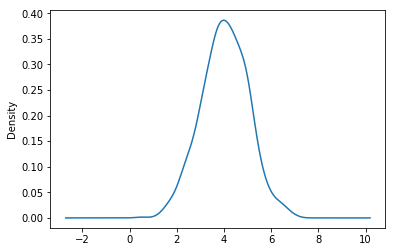

In [3]:
import pandas as pd
%matplotlib inline

def data_distribution(mu, sigma):
    while True:
        z = sigma*np.random.randn() + mu
        yield z
        
data_point = data_distribution(mu=4, sigma=1)
pd.Series(next(data_point) for _ in range(1_000)).plot(kind='kde');

## Task

- Create a generator $\mathcal{G}$ with keras

## Hints

- Recall the interface for a generator

<img src="images/Fancy G.svg" alt="Drawing" style="width: 300px;"/>

- Keep it simple

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Activation

G = Sequential()
G.add(Dense(200, input_shape=(1,)))
G.add(Dense(1))
G.summary()
#raise NotImplementedError()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 601.0
Trainable params: 601
Non-trainable params: 0.0
_________________________________________________________________


In [5]:
G.input_shape, G.output_shape, G.losses

((None, 1), (None, 1), [])

# Generator Tests

In [6]:
import numpy as np
import keras

def test_generator(G):
    assert type(G) == keras.models.Sequential
    assert G.input_shape == (None, 1)
    assert G.output_shape == (None, 1)
    assert G.losses == []
    X_fake = G.predict(Z_)
    assert X_fake.shape == (BS_, 1)
    return X_fake
    
X_FAKE_ = test_generator(G)
passed()

✅


## Task

- Define a discriminator $\mathcal{D}$ in keras

## Hint

- Recall the interface for a discriminator

<img src="images/Fancy D.svg" alt="Discriminator" style="width: 300px;"/>

- Keep it simple

In [7]:
from keras.models import Sequential
from keras.layers import Dense

D = Sequential()
D.add(Dense(200, input_shape=(1,)))
D.add(Dense(1, activation='sigmoid'))
D.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
D.summary()
#raise NotImplementedError()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 601.0
Trainable params: 601
Non-trainable params: 0.0
_________________________________________________________________


# Discriminator Tests

In [8]:
import numpy as np

def test_discriminator(D):
    assert type(D) == keras.models.Sequential
    assert D.input_shape == (None, 1)
    assert D.output_shape == (None, 1)
    assert D.loss == 'binary_crossentropy'
    assert D.metrics == ['accuracy']
    assert type(D.optimizer) == keras.optimizers.Adam

    p_ = D.predict(X_FAKE_)
    assert np.all((0 <= p_) & (p_ <= 1))
    
test_discriminator(D)
passed()

✅


## Task

- Sample 100 data points from $\mathcal{G}$ and plot them

## Requirements

- Save the resulting data points into a python variable called `X_fake`
- Use $\text{Uniform}(-1, +1)$ for the generator's noise distribution throughout
- Use a *kernel density estimation* plot

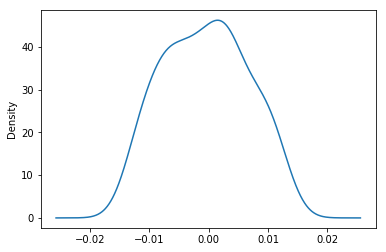

In [9]:
X_fake = G.predict(np.random.uniform(low=-1, high=1, size=100))
pd.Series(X_fake.ravel()).plot(kind='kde');
#raise NotImplementedError()

In [10]:
print(len(X_fake))
X_fake[:5]

100


array([[-0.0013419 ],
       [-0.00686447],
       [-0.00331506],
       [-0.00713317],
       [-0.01116296]], dtype=float32)

# Generator Sampling Tests

In [11]:
import PIL

assert type(np.array(X_fake)) == np.ndarray
X_fake_ = X_fake.flatten()
assert len(X_fake_) == 100

passed()

✅


# Pretraining $\mathcal{D}$

## Task

- Generate the training data

## Requirements

- Sample 100 data points from the `data_point` python generator and save them into a python variable `X_real`
- Concatenate them into one variable $\mathbf{X} = [\mathbf{X\_fake} \ \mathbf{;} \ \mathbf{X\_real}]$ and create a corresponding set of labels $\mathbf{y} = [\mathbf{0} \ {\bf ;} \ \mathbf{1}]$ (where `;` implies concatenation)
- Save the data points into a python variable called `X` and the labels into a python variable called `y`

In [12]:
X_real = np.asarray([next(data_point) for _ in range(100)]).reshape((100, 1))
X = np.concatenate((X_fake, X_real))
y = np.asarray([1]*100 + [0]*100)

# Data Generation Tests

In [13]:
assert len(X) == NB_SAMPLE_*2
assert len(y) == NB_SAMPLE_*2
assert np.all(y[NB_SAMPLE_:] == 0)
assert np.all(y[:NB_SAMPLE_] == 1)
assert X.shape[1:] == D.input_shape[1:]
assert y.ndim == len(D.output_shape[1:])

X_, y_ = X[IDXS_][:BS_], y[IDXS_][:BS_]
loss_, accuracy_ = D.evaluate(X_, y_, verbose=0)

passed()

✅


## Task

- Fit $\mathcal{D}$ on the training data `(X, y)`

In [14]:
loss, acc = D.train_on_batch(X, y)

# Fitting $\mathcal{D}$ Tests

In [15]:
new_loss_, new_accuracy_ = D.evaluate(X_, y_, verbose=0)
assert new_loss_ <= loss_
assert new_accuracy_ >= accuracy_

passed()

✅


## Task

- Save your models

## Requirements

- Save $\mathcal{G}$ to a file `G.h5` and save $\mathcal{D}$ to a file `D.h5`

In [16]:
G.save("G.h5", overwrite=True)
D.save("D.h5", overwrite=True)

# Model Save Tests

In [17]:
import os
from keras.models import load_model

assert os.path.isfile('G.h5')
assert os.path.isfile('D.h5')

for fname_, f in zip(['G.h5', 'D.h5'], [test_generator, test_discriminator]):
    model_ = load_model(fname_)
    f(model_)
    
passed()

/Users/srianant/anaconda/envs/dl/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


✅
